# Neural Agent Memory Analysis

This notebook analyzes the training memory of a neural agent to understand its performance and behavior over time. It loads the agent's memory, calculates win rates, and visualizes action distributions.

In [19]:
# Import necessary libraries
from pathlib import Path
import pickle
import numpy as np
from typing import List, Tuple

# Assuming src is in the python path or adjust sys.path if needed
import sys
sys.path.append('../') # Example if running from notebooks dir

from src.engine.actions import Action
from src.analysis.memory_analyzer import analyze_win_loss_and_steps, calculate_win_rate_over_time, analyze_and_plot_win_rates_by_starting_position

In [20]:
from src.nn.memory_data import MemoryData
from src.analysis.memory_loader import load_memory

# Get the user's home directory
home_dir = Path.home()

# Construct the path to the Downloads folder (or wherever your memory file is)
downloads_dir = home_dir / "Downloads"

# Find the most recently updated .pkl file in the Downloads folder
pkl_files = list(downloads_dir.glob("*.pkl"))
if not pkl_files:
    raise FileNotFoundError("No .pkl memory files found in Downloads")
memory_file = max(pkl_files, key=lambda f: f.stat().st_mtime)

# Load the memory
agent_memory = load_memory(memory_file)

Successfully loaded 8192 episodes from C:\Users\timmie\Downloads\memory_8192.pkl.


Analyzed 8192 completed episodes for outcomes and steps.
First player episodes: 4084, Second player episodes: 4108
Total actions analyzed: 0
Analyzed 8192 completed episodes for outcomes and steps.
First player episodes: 4084, Second player episodes: 4108
Total actions analyzed: 0
Overall win rate (latest 32 episodes): 54.60% over 8192 episodes
Win rate when agent starts first (latest chunk): 56.37% over 4084 episodes
Win rate when agent starts second (latest chunk): 52.85% over 4108 episodes


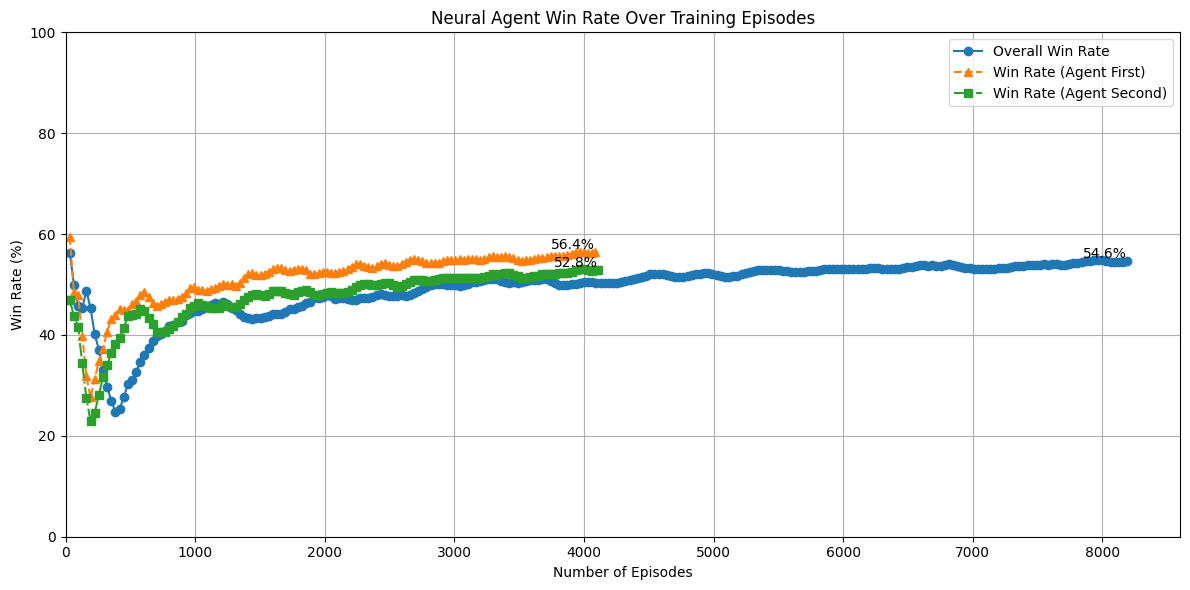

No action data to plot.


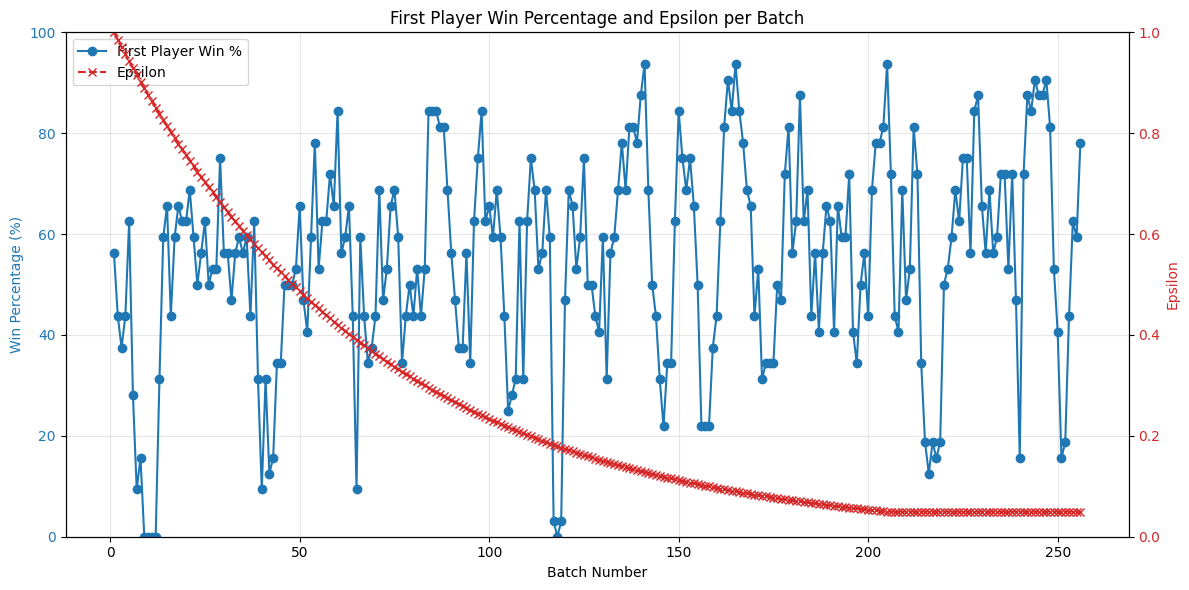


--- Analysis Summary ---
Total valid episodes analyzed: 8192
Overall Win Rate: 54.60%
Average steps per episode: 136.16
Median steps per episode: 136.0
Min steps per episode: 49
Max steps per episode: 245


In [21]:
from src.analysis.visualization import plot_batch_win_percentage

if agent_memory:
    # Analyze win/loss outcomes, steps per episode, and action counts
    episode_outcomes, first_player_outcomes, second_player_outcomes, episode_steps, action_distribution = analyze_win_loss_and_steps(agent_memory.episodes)

    if episode_outcomes:
        # Calculate win rate over time (e.g., in chunks of 100 episodes)
        chunk_size = agent_memory.batch_size

        chunks, rates = calculate_win_rate_over_time(episode_outcomes, chunk_size)

        # Plot win rates by starting position (using existing function)
        analyze_and_plot_win_rates_by_starting_position(memory=agent_memory.episodes, chunk_size=chunk_size)

        # Plot batch win percentage and epsilon overlay using new helper
        plot_batch_win_percentage(agent_memory)

        # Print overall summary
        overall_win_rate = np.mean(episode_outcomes) * 100
        print(f"\n--- Analysis Summary ---")
        print(f"Total valid episodes analyzed: {len(episode_outcomes)}")
        print(f"Overall Win Rate: {overall_win_rate:.2f}%")

        # Calculate and print step statistics
        if episode_steps:
            avg_steps = np.mean(episode_steps)
            median_steps = np.median(episode_steps)
            min_steps = np.min(episode_steps)
            max_steps = np.max(episode_steps)
            print(f"Average steps per episode: {avg_steps:.2f}")
            print(f"Median steps per episode: {median_steps}")
            print(f"Min steps per episode: {min_steps}")
            print(f"Max steps per episode: {max_steps}")
        else:
            print("No step data available for completed episodes.")

    else:
        print("No valid episode outcomes found to calculate statistics.")
else:
    print("Could not load memory or memory is empty.")
